[35/1590] 08529_gc_000.png


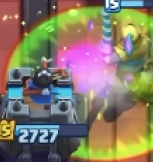

Exiting…


SystemExit: 0

/Users/vincecimino/dev/ClashVision/venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
# Minimal image labeler: press 0 / 1 / 2 (or type 'exit' to stop).
from pathlib import Path
from PIL import Image
from IPython.display import display, clear_output
import csv, sys, os

# NEW: Torch + TV imports for inference
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet50_Weights

os.chdir("../")
from global_stuff.constants import BASE_DIR

# === EDIT THESE ===
INPUT_DIR  = BASE_DIR / "human_annotated_yolo/goblin-curse-validation"  # folder with patches (png/jpg/jpeg)
CKPT_PATH  = BASE_DIR / "models/goblin-curse-classifier-1/resnet50_best.pt"
NUM_CLASSES = 3
# ===================

csv_path = INPUT_DIR / "labels.csv"

# ---------- Load prior labels (to resume) ----------
labeled = set()
if csv_path.exists():
    with csv_path.open("r", newline="") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row:
                continue
            if row[0].strip().lower() == "filename":
                continue
            labeled.add(row[0])

# ---------- Prepare list of images to process (exclude already labeled) ----------
exts = (".png", ".jpg", ".jpeg")
imgs = sorted([p for p in INPUT_DIR.iterdir()
               if p.is_file() and p.suffix.lower() in exts and p.name not in labeled])

if not imgs:
    print("No new images to label.")
else:
    print(f"{len(imgs)} images to label.")

# ---------- Open CSV for appending (create header if new) ----------
new_file = not csv_path.exists()
csv_file = csv_path.open("a", newline="")
writer = csv.writer(csv_file)
if new_file:
    writer.writerow(["filename", "label"])
    csv_file.flush()

# ---------- Load model for default guesses ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_model(num_classes: int):
    model = models.resnet50(weights=None)
    # Replace head for our 3-class task
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def load_checkpoint(model, ckpt_path: Path):
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location="cpu")
    missing, unexpected = model.load_state_dict(state, strict=False)
    if missing or unexpected:
        print(f"[warn] load_state_dict: missing={missing}, unexpected={unexpected}")
    return model

# Use the same transforms as standard ResNet-50 weights (likely what you trained with)
inference_tf = ResNet50_Weights.DEFAULT.transforms()

model = None
try:
    model = build_model(NUM_CLASSES)
    model = load_checkpoint(model, CKPT_PATH)
    model.to(device).eval()
    print(f"Loaded classifier: {CKPT_PATH}")
except Exception as e:
    print(f"[warning] Could not load model for default guesses: {e}")
    model = None

@torch.no_grad()
def default_guess(pil_img: Image.Image):
    """Return (pred_label:int, confidence:float in [0,1]) or (None, None) if model unavailable."""
    if model is None:
        return None, None
    x = inference_tf(pil_img).unsqueeze(0).to(device)
    logits = model(x)
    probs = F.softmax(logits, dim=1)[0]
    conf, pred = torch.max(probs, dim=0)
    return int(pred.item()), float(conf.item())

try:
    for idx, img_path in enumerate(imgs, 1):
        clear_output(wait=True)
        print(f"[{idx}/{len(imgs)}] {img_path.name}")

        # Show the patch
        try:
            img = Image.open(img_path).convert("RGB")
            display(img)
        except Exception as e:
            print(f"(Couldn't display image: {e})")
            img = None

        # Compute default model guess (if model loaded)
        pred_label, pred_conf = (None, None)
        if img is not None:
            pred_label, pred_conf = default_guess(img)

        # Compose prompt with default
        if pred_label is not None:
            prompt = f"Enter label (0/1/2) or press Enter to accept [{pred_label} @ {pred_conf:.1%}] (type 'exit'): "
        else:
            prompt = "Enter label (0/1/2) (type 'exit'): "

        # Prompt loop
        while True:
            ans = input(prompt).strip().lower()
            if ans == "" and pred_label is not None:
                ans = str(pred_label)  # accept default
            if ans in {"0", "1", "2"}:
                writer.writerow([img_path.name, ans])
                csv_file.flush()
                break
            elif ans == "exit":
                print("Exiting…")
                csv_file.close()
                sys.exit(0)
            else:
                print("Please enter 0, 1, 2, press Enter to accept default, or type 'exit'.")
    print("Done labeling all images.")
finally:
    try:
        csv_file.close()
    except Exception:
        pass


In [30]:
# Delete files listed in the first CSV column from REMOVE_DIR
from pathlib import Path
import csv

CSV_PATH   = BASE_DIR/"clock-validation/labels.csv"   # CSV with filenames in col 1
REMOVE_DIR = BASE_DIR/"spell-validation-dataset/clock"   # folder to delete from

deleted = missing = 0
with CSV_PATH.open(newline="") as f:
    for row in csv.reader(f):
        if not row:
            continue
        name = Path(row[0].strip()).name      # use only the basename
        if not name or name.lower() == "filename":  # skip common header
            continue
        p = REMOVE_DIR / name
        try:
            p.unlink()
            deleted += 1
        except FileNotFoundError:
            missing += 1

print(f"Deleted: {deleted}, missing: {missing}")


Deleted: 2007, missing: 865


In [7]:
from pathlib import Path
import csv, random, json, time
from collections import Counter

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np

from global_stuff.constants import BASE_DIR

# edit these:
CSV_PATH = BASE_DIR / "human_annotated_yolo/goblin-curse-validation/labels.csv"   # first col: filename, second col: label 0/1/2
IMG_DIR  = BASE_DIR / "human_annotated_yolo/goblin-curse-validation"     # where the images live
OUT_DIR  = BASE_DIR / "models/goblin-curse-classifier-1"
OUT_DIR.mkdir(parents=True, exist_ok=True)

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("mps")
device


device(type='mps')

In [8]:
rows = []
with CSV_PATH.open("r", newline="") as f:
    for row in csv.reader(f):
        if not row: 
            continue
        name = Path(row[0]).name
        if name.lower() in {"filename", ""}:
            continue
        label = row[1].strip() if len(row) > 1 else ""
        if label not in {"0", "1", "2"}:
            continue

        p = IMG_DIR / name
        if not p.exists():
            # try common jpg/jpeg variants
            candidates = [name.replace(".jpg", ".jpeg"),
                          name.replace(".jpeg", ".jpg"),
                          name.replace(".JPG", ".jpg")]
            for c in candidates:
                q = IMG_DIR / Path(c).name
                if q.exists():
                    p = q
                    break
        if p.exists():
            rows.append((p, int(label)))

print(f"Found {len(rows)} labeled images")
print("Class counts:", Counter(y for _, y in rows))
assert rows, "No labeled images found. Check paths."


Found 1136 labeled images
Class counts: Counter({1: 688, 0: 410, 2: 38})


In [9]:
def stratified_split(items, val_frac=0.2):
    by = {}
    for p, y in items:
        by.setdefault(y, []).append((p, y))
    train, val = [], []
    for y, lst in by.items():
        random.shuffle(lst)
        k = max(1, int(len(lst) * val_frac))
        val += lst[:k]
        train += lst[k:]
    random.shuffle(train); random.shuffle(val)
    return train, val

train_items, val_items = stratified_split(rows, val_frac=0.2)
len(train_items), len(val_items)


(910, 226)

In [10]:
# Cell 4 — dataset + transforms (safe)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # allow truncated JPGs

IMG_SIZE = 96
mean = (0.485, 0.456, 0.406)
std  = (0.229, 0.224, 0.225)

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

class ImgCsvDataset(Dataset):
    def __init__(self, items, tfm): 
        self.items, self.tfm = items, tfm
    def __len__(self): 
        return len(self.items)
    def __getitem__(self, i):
        p, y = self.items[i]
        try:
            img = Image.open(p).convert("RGB")
        except Exception as e:
            # Return a sentinel to drop later in collate_fn
            print(f"[WARN] Bad image skipped: {p} ({e})")
            return None
        return self.tfm(img), y

def collate_drop_none(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        # produce an empty batch the loop can handle
        return torch.empty(0, 3, IMG_SIZE, IMG_SIZE), torch.empty(0, dtype=torch.long)
    xs, ys = zip(*batch)
    return torch.stack(xs), torch.tensor(ys)



In [11]:
# Cell 5 — dataloaders
BATCH = 64
NUM_WORKERS = 0              # start at 0 to reveal real errors (esp. on macOS/MPS)
PIN = (device.type == "cuda")

train_ds = ImgCsvDataset(train_items, train_tf)
val_ds   = ImgCsvDataset(val_items,   val_tf)

print("train_ds:", len(train_ds), "samples | val_ds:", len(val_ds))

train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=PIN,
                      persistent_workers=False, collate_fn=collate_drop_none)
val_dl   = DataLoader(val_ds, batch_size=BATCH, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN,
                      persistent_workers=False, collate_fn=collate_drop_none)


train_ds: 910 samples | val_ds: 226


In [13]:
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch
import torch.nn as nn

NUM_CLASSES = 3
FREEZE_BACKBONE = True      # set False to fine-tune everything
PRETRAINED_IMAGENET = True  # set False to train from scratch
CKPT_PATH = None            # e.g., Path("/path/to/resnet50_best.pt") to resume/finetune
use_amp = False
# ==== Model ====
weights = ResNet50_Weights.DEFAULT if PRETRAINED_IMAGENET else None
model = models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# (optional) freeze backbone
if FREEZE_BACKBONE:
    for name, p in model.named_parameters():
        p.requires_grad = name.startswith("fc.")
else:
    for p in model.parameters():
        p.requires_grad = True

# (optional) load your checkpoint AFTER replacing the head.
if CKPT_PATH:
    state = torch.load(CKPT_PATH, map_location="cpu")
    missing, unexpected = model.load_state_dict(state, strict=False)
    print(f"Loaded ckpt. Missing keys: {missing} | Unexpected keys: {unexpected}")

model.to(device)
scaler  = torch.cuda.amp.GradScaler(enabled=use_amp)
criterion = nn.CrossEntropyLoss()

# Optimizer on trainable params only
optimizer = torch.optim.Adam((p for p in model.parameters() if p.requires_grad), lr=1e-3)

# ==== Train/Eval helpers ====
def run_epoch(dl, train_mode=True):
    model.train(train_mode)
    total, correct, loss_sum = 0, 0, 0.0

    for xb, yb in dl:
        xb = xb.to(device, non_blocking=True)
        yb = torch.as_tensor(yb, device=device, dtype=torch.long)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            out = model(xb)
            loss = criterion(out, yb)

        if train_mode:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        loss_sum += float(loss) * xb.size(0)
        pred = out.argmax(1)
        correct += int((pred == yb).sum())
        total += xb.size(0)

    return loss_sum / total, correct / total

# ==== Train loop ====
best_acc = 0.0
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_dl, True)
    val_loss, val_acc = run_epoch(val_dl, False)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), OUT_DIR / "resnet50_best.pt")

print("Best val acc:", best_acc)

/var/folders/80/_dzzdcm164ddspm75qh4pkgr0000gn/T/ipykernel_28834/870726561.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = torch.cuda.amp.GradScaler(enabled=use_amp)
/var/folders/80/_dzzdcm164ddspm75qh4pkgr0000gn/T/ipykernel_28834/870726561.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/var/folders/80/_dzzdcm164ddspm75qh4pkgr0000gn/T/ipykernel_28834/870726561.py:58: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss_sum += float(loss) * xb.size(0)


Epoch 01 | train 0.8505/0.592 | val 0.7369/0.646
Epoch 02 | train 0.6912/0.721 | val 0.6846/0.743
Epoch 03 | train 0.6286/0.779 | val 0.6351/0.743
Epoch 04 | train 0.5851/0.795 | val 0.5972/0.774
Epoch 05 | train 0.5418/0.821 | val 0.5703/0.796
Epoch 06 | train 0.5186/0.808 | val 0.5390/0.832
Epoch 07 | train 0.4746/0.841 | val 0.5182/0.823
Epoch 08 | train 0.4545/0.844 | val 0.5065/0.814
Epoch 09 | train 0.4590/0.838 | val 0.4987/0.819
Epoch 10 | train 0.4309/0.834 | val 0.4818/0.832
Epoch 11 | train 0.4122/0.855 | val 0.4531/0.854
Epoch 12 | train 0.3882/0.876 | val 0.4465/0.841
Epoch 13 | train 0.3778/0.873 | val 0.4439/0.836
Epoch 14 | train 0.3566/0.880 | val 0.4355/0.832
Epoch 15 | train 0.3560/0.884 | val 0.4270/0.841
Epoch 16 | train 0.3499/0.877 | val 0.4124/0.827
Epoch 17 | train 0.3163/0.902 | val 0.4131/0.832
Epoch 18 | train 0.3317/0.897 | val 0.4057/0.863
Epoch 19 | train 0.3290/0.900 | val 0.4136/0.858
Epoch 20 | train 0.3193/0.893 | val 0.4157/0.850
Epoch 21 | train 0.3

In [50]:
def confusion(dl):
    cm = np.zeros((3, 3), dtype=int)
    model.eval()
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device)
            pred = model(xb).argmax(1).cpu().numpy()
            yb = np.array(yb)
            for t, p in zip(yb, pred):
                cm[t, p] += 1
    return cm

model.load_state_dict(torch.load(OUT_DIR / "shufflenet_v2_x0_5_best.pt", map_location=device))
cm = confusion(val_dl)
print("Confusion (rows=true, cols=pred):\n", cm)

with (OUT_DIR / "meta.json").open("w") as f:
    json.dump({"counts": dict(counts), "best_val_acc": float(best_acc),
               "confusion": cm.tolist()}, f, indent=2)

print("Saved model to:", (OUT_DIR / "shufflenet_v2_x0_5_best.pt").resolve())


/var/folders/80/_dzzdcm164ddspm75qh4pkgr0000gn/T/ipykernel_95062/2647130393.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  yb = np.array(yb)


Confusion (rows=true, cols=pred):
 [[ 88   2   1]
 [ 12 467   0]
 [  1   0   2]]
Saved model to: /Users/vincecimino/dev/ClashVision/models/clock-classifier-3/shufflenet_v2_x0_5_best.pt


[2007/2007] fffe6c98.jpg


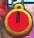

Done labeling all images.


In [25]:
# Smart image labeler with model prefill (0/1/2). Press Enter to accept suggestion.
from pathlib import Path
from PIL import Image
from IPython.display import display, clear_output
import shutil, csv, sys, os

import torch, torch.nn as nn
from torchvision import transforms, models

from global_stuff.constants import BASE_DIR
INPUT_DIR  = BASE_DIR / "spell-validation-dataset/clock"  # images to label
OUTPUT_DIR = BASE_DIR / "clock-validation"                # labels.csv + copied images
MODEL_PATH = BASE_DIR / "models/clock-classifier/mobilenetv3_small_best.pt"  # <- edit

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
csv_path = OUTPUT_DIR / "labels2.csv"

# --- Load prior labels (to resume) ---
labeled = set()
if csv_path.exists():
    with csv_path.open("r", newline="") as f:
        for name, *_ in csv.reader(f):
            labeled.add(name)

# --- Collect images (skip already labeled) ---
exts = ("*.jpg","*.jpeg","*.JPG","*.JPEG")
imgs = []
for ext in exts:
    imgs += [p for p in INPUT_DIR.glob(ext) if p.name not in labeled]
imgs = sorted(imgs)
print(f"{len(imgs)} images to label.")

weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
model = models.mobilenet_v3_small(weights=weights)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 3)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval().to(device)

# Same normalization as validation
IMG_SIZE = 96
tfm = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

# --- Open CSV for appending (write header if new) ---
new_file = not csv_path.exists()
csv_file = csv_path.open("a", newline="")
writer = csv.writer(csv_file)
if new_file:
    writer.writerow(["filename", "label"])
    csv_file.flush(); os.fsync(csv_file.fileno())

try:
    with torch.no_grad():
        for idx, img_path in enumerate(imgs, 1):
            clear_output(wait=True)
            print(f"[{idx}/{len(imgs)}] {img_path.name}")

            # Load/show image and get model suggestion
            try:
                pil = Image.open(img_path).convert("RGB")
                display(pil)
                x = tfm(pil).unsqueeze(0).to(device)
                probs = torch.softmax(model(x), dim=1).squeeze(0).cpu().numpy()
                suggested = int(probs.argmax())
                conf = float(probs[suggested])
            except Exception as e:
                print(f"(Model/picture error, defaulting to 1): {e}")
                suggested, conf = 1, 0.0

            # Prompt (Enter accepts suggestion)
            while True:
                ans = input(f"{suggested}").strip().lower()
                if ans == "exit":
                    print("Exiting…")
                    csv_file.close()
                    sys.exit(0)
                if ans in {"", "0", "1", "2"}:
                    label = str(suggested) if ans == "" else ans
                    # write & sync immediately
                    writer.writer
                    ow([img_path.name, label])
                    csv_file.flush(); os.fsync(csv_file.fileno())
                    # copy image immediately
                    shutil.copy2(img_path, OUTPUT_DIR / img_path.name)
                    break
                else:
                    print("Please enter 0, 1, 2, press Enter, or type 'exit'.")
    print("Done labeling all images.")
finally:
    try:
        csv_file.close()
    except Exception:
        pass


In [ ]:
import torch
from torchvision import transforms
import torchvision.models as models
from PIL import Image
from pathlib import Path
from global_stuff.constants import BASE_DIR

def get_detection_count(img_path, model_path=BASE_DIR/"models/clock-classifier-2/best.pt"):
    model = models.shufflenet_v2_x0_5(pretrained=False)
    model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 3)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0)
    
    with torch.no_grad():
        output = model(img_tensor)
        # Assuming binary classification (0 or 1)
        prediction = torch.argmax(output, dim=1).item()
        confidence = torch.softmax(output, dim=1).max().item()
    
    return prediction, confidence

# Usage:
pred, conf = get_detection_count("/Users/vincecimino/dev/ClashVision/clock-validation/9cf60d62.jpg")
print(f"Prediction: {pred}, Confidence: {conf:.3f}")

/Users/vincecimino/dev/ClashVision/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vincecimino/dev/ClashVision/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Prediction: 1, Confidence: 0.934


In [15]:
reason = input("why are you gay?")
while True:
    print("That is wrong. Try again.")
    reason = input("why are you gay?")

KeyboardInterrupt: Interrupted by user